# Dubai Satellite Imagery Semantic Segmentation
Humans in the Loop has published an open access dataset annotated for a joint project with the Mohammed Bin Rashid Space Center in Dubai, the UAE. 

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The images were segmented by the trainees of the Roia Foundation in Syria.

Original Dataset Link: https://humansintheloop.org/resources/datasets/semantic-segmentation-dataset/

# Installing & Importing Libraries

In [21]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from patchify import patchify
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

from sklearn.preprocessing import MinMaxScaler

# Data Augmentation using Albumentations Library
[Albumentations](https://albumentations.ai/) is a Python library for fast and flexible image augmentations. Albumentations efficiently implements a rich variety of image transform operations that are optimized for performance, and does so while providing a concise, yet powerful image augmentation interface for different computer vision tasks, including object classification, segmentation, and detection.

Data augmentation is done by the following techniques:

1. Random Cropping
2. Horizontal Flipping
3. Vertical Flipping
4. Rotation
5. Random Brightness & Contrast
6. Contrast Limited Adaptive Histogram Equalization (CLAHE)
7. Grid Distortion
8. Optical Distortion

In [78]:
def augment(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)
    
    return transform

In [67]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 16

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(10, 10)) 

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 12))  

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original Image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original Mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed Image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed Mask', fontsize=fontsize)
        
    plt.savefig('sample_augmented_image.png', facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)

In [17]:
!pwd

/Users/Alenka/code/Alastair908/GlobalGreening


In [22]:
dataset_root_folder = '/Users/Alenka/code/Alastair908/Downloads'
dataset_name = 'Dubai_data'
image_patch_size = 256
minmaxscaler = MinMaxScaler()

In [ ]:
imgs = []
labels = []

data_path = 'flowers/'

for (cl, i) in classes.items():
    images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg')>0]
        for img in tqdm(images_path[:300]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

In [83]:
# loading images and masks into the list - new version wihtout cv2.

image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
    for tile_id in range(1,9):
        for image_id in range(1,10):                    
            if image_type == 'images':
                image_extension = 'jpg'
                path_image = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
                print(path_image)
                image = Image.open(path_image)
                image_dataset.append(np.array(image))
                print('appended image')
            elif image_type == 'masks':
                image_extension = 'png'
                path_mask = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
                print(path_mask)
                mask = Image.open(path_mask)
                mask_dataset.append(np.array(mask))
                print('appended mask')

/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_001.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_002.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_003.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_004.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_005.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_006.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_007.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_008.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_009.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 2/images/image_part_001.jpg
appended image


appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_006.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_007.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_008.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 5/masks/image_part_009.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_001.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_002.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_003.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_004.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_005.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_006.png
appended mask
/Users

In [73]:
# loading images and masks into the list and using cv2

image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
    for tile_id in range(1,9):
        for image_id in range(1,10):                    
            if image_type == 'images':
                image_extension = 'jpg'
                path = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
                print(path)
                image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
                image_dataset.append(image)
                print('appended image')
            elif image_type == 'masks':
                image_extension = 'png'
                path = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
                print(path)
                mask = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                mask_dataset.append(mask)
                print('appended mask')

/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_001.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_002.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_003.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_004.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_005.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_006.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_007.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_008.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 1/images/image_part_009.jpg
appended image
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 2/images/image_part_001.jpg
appended image


appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_002.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_003.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_004.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_005.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_006.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_007.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_008.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 6/masks/image_part_009.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 7/masks/image_part_001.png
appended mask
/Users/Alenka/code/Alastair908/Downloads/Dubai_data/Tile 7/masks/image_part_002.png
appended mask
/Users

In [84]:
len(image_dataset), len(mask_dataset)

(72, 72)

In [85]:
image = image_dataset[0] 
mask = mask_dataset[0] 

print(image.shape, mask.shape)

(644, 797, 3) (644, 797, 3)


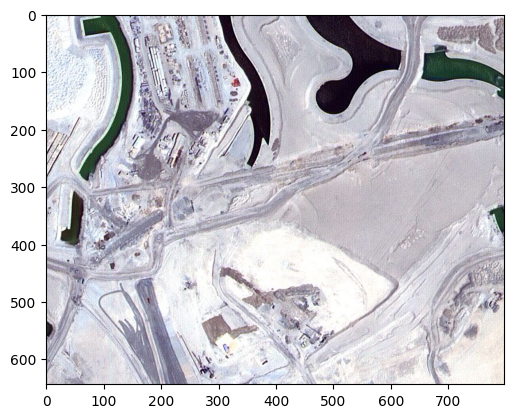

In [86]:
plt.imshow(image_dataset[0])

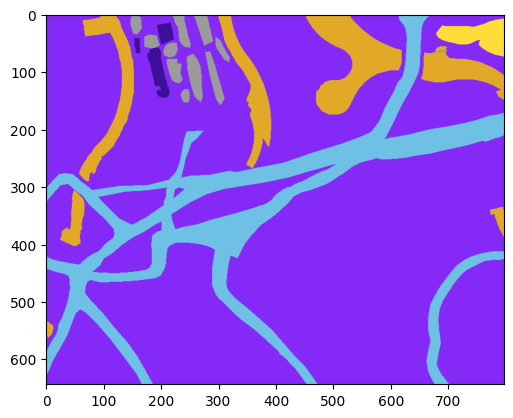

In [87]:
plt.imshow(mask_dataset[0])

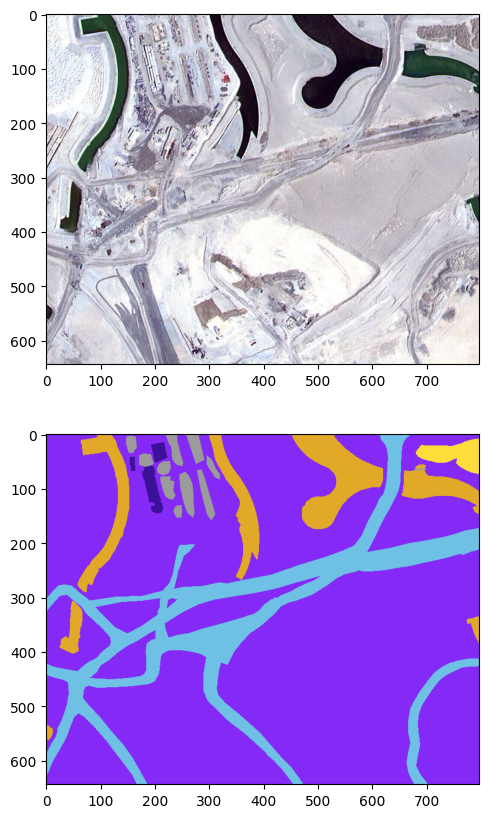

In [88]:
visualize(image, mask)

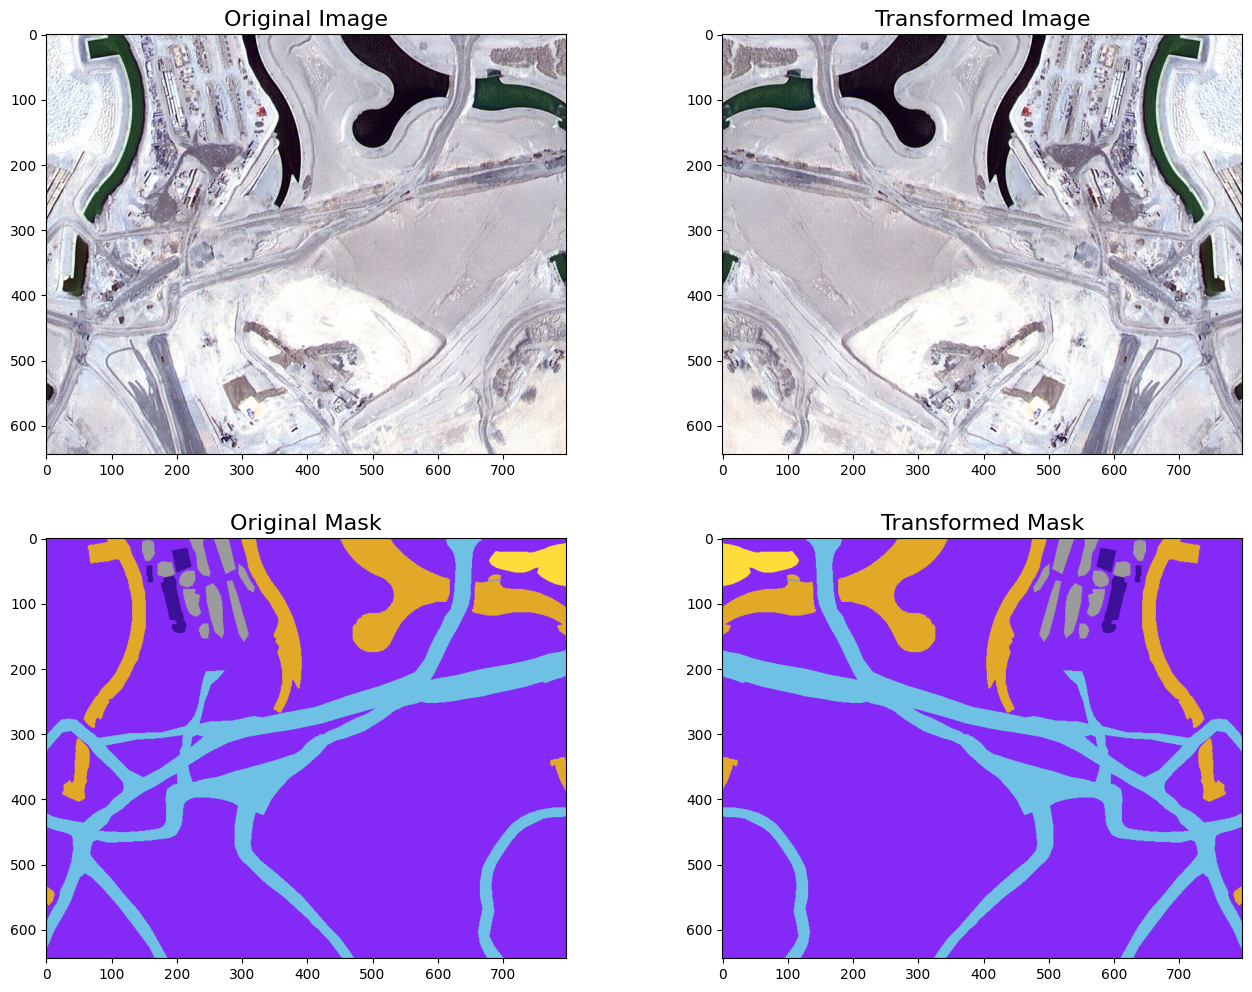

In [89]:
#trying out one function 
aug = A.HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

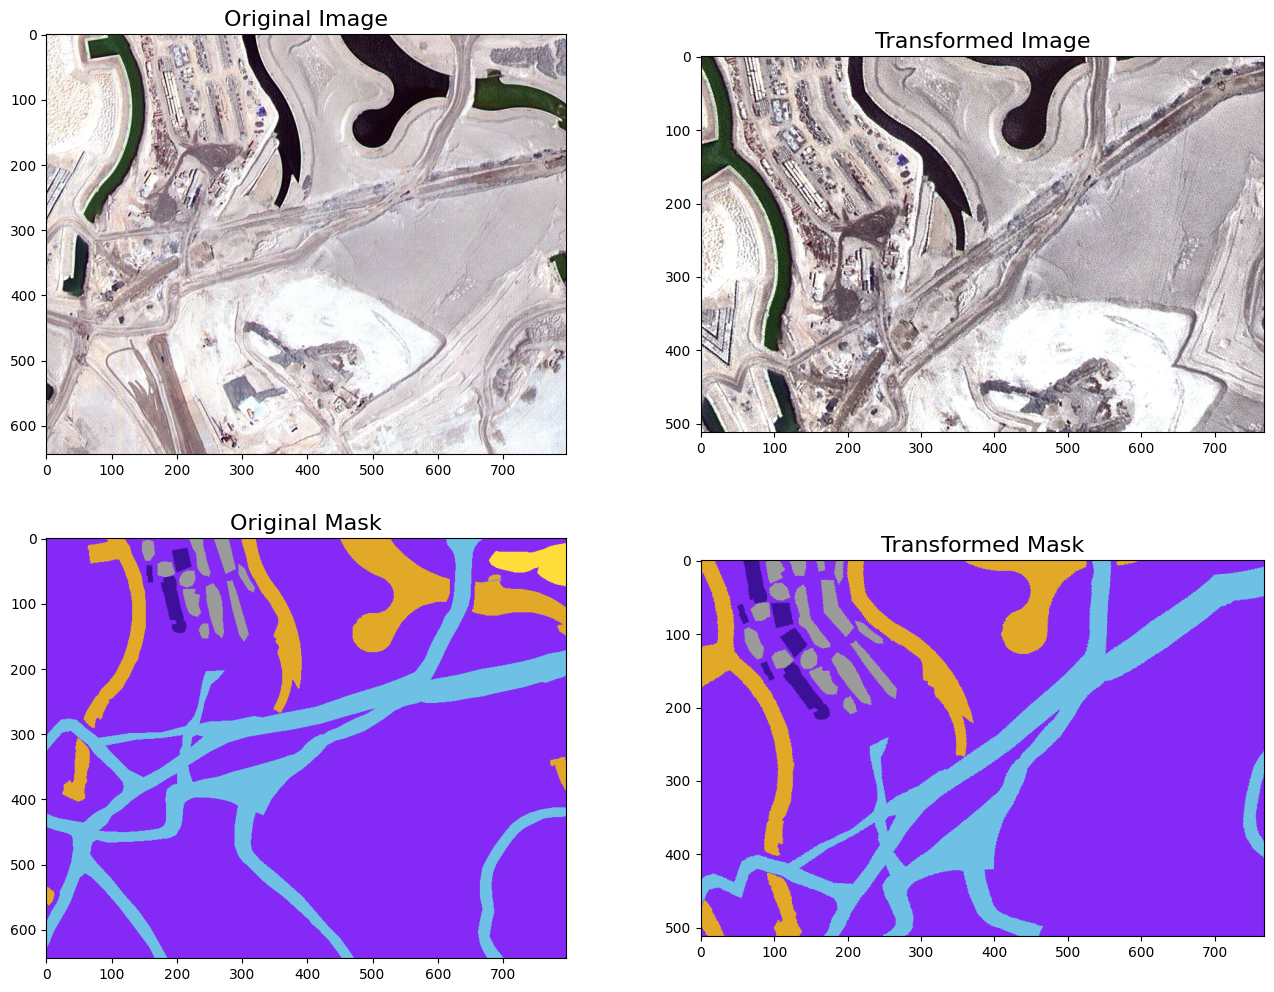

In [81]:
# testing out tranform function

transform = augment(768, 512)
transformed = transform(image=image, mask=mask)
transformed_image = transformed['image']
transformed_mask = transformed['mask']

cv2.imwrite('./image_test.png',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
cv2.imwrite('./mask_test.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

visualize(transformed_image, transformed_mask, image, mask)

# Saving Augmented Images to Disk
I have already performed data augmentation and saved the images. I am not running it's code in this notebook. It is a very time consuming process, so be patient while the code cell runs!

In [82]:
!mkdir ../Downloads/Dubai_data/aug_images
!mkdir ../Downloads/Dubai_data/aug_masks

In [ ]:
# not needed 

# images_dir = '../input/dubai-aerial-imagery-dataset/train_images/train/'
# masks_dir = '../input/dubai-aerial-imagery-dataset/train_masks/train/'

# file_names = np.sort(os.listdir(images_dir)) 
# file_names = np.char.split(file_names, '.')
# filenames = np.array([])
# for i in range(len(file_names)):
#     filenames = np.append(filenames, file_names[i][0])

In [ ]:
def augment_dataset(count):
    '''Function for data augmentation
        Input:
            count - total no. of images after augmentation = initial no. of images * count
        Output:
            writes augmented images (input images & segmentation masks) to the working directory
    '''
    transform = augment(480, 480) 
    
    i = 0
    for i in range(count):
        for image in image_dataset:
            img = image_dataset[i]
            mask = mask_dataset[i] 
            
            transformed = transform(image=img, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask'] 
                
            cv2.imwrite('./aug_images/aug_{}_'.format(str(i+1))+file+'.jpg',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
            cv2.imwrite('./aug_masks/aug_{}_'.format(str(i+1))+file+'.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

In [ ]:
def augment_dataset(count):
    '''Function for data augmentation
        Input:
            count - total no. of images after augmentation = initial no. of images * count
        Output:
            writes augmented images (input images & segmentation masks) to the working directory
    '''
    transform_1 = augment(512, 512)
    transform_2 = augment(480, 480)
    transform_3 = augment(512, 512)
    transform_4 = augment(800, 800)
    transform_5 = augment(1024, 1024)
    transform_6 = augment(800, 800)
    transform_7 = augment(1600, 1600)
    transform_8 = augment(1920, 1280)
    
    i = 0
    for i in range(count):
        for file in filenames:
            tile = file.split('_')[1]
            img = cv2.imread(images_dir+file+'.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(masks_dir+file+'.png')
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            if tile == 't1':
                transformed = transform_1(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t2':
                transformed = transform_2(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t3':
                transformed = transform_3(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t4':
                transformed = transform_4(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t5':
                transformed = transform_5(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t6':
                transformed = transform_6(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t7':
                transformed = transform_7(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
            elif tile =='t8':
                transformed = transform_8(image=img, mask=mask)
                transformed_image = transformed['image']
                transformed_mask = transformed['mask']
                
            cv2.imwrite('./aug_images/aug_{}_'.format(str(i+1))+file+'.jpg',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
            cv2.imwrite('./aug_masks/aug_{}_'.format(str(i+1))+file+'.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))

In [ ]:
augment_dataset(8)

In [ ]:
!zip -r aug_images.zip './aug_images/'
!zip -r aug_masks.zip './aug_masks/'

In [ ]:
!rm -rf './aug_images/'
!rm -rf './aug_masks/'

# Working with Augmented Dataset

In [ ]:
train_images = "../input/augmented-dubai-aerial-imagery-dataset/train_images/"
train_masks = "../input/augmented-dubai-aerial-imagery-dataset/train_masks/"
val_images = "../input/augmented-dubai-aerial-imagery-dataset/val_images/"
val_masks = "../input/augmented-dubai-aerial-imagery-dataset/val_masks/"

In [ ]:
file_names = np.sort(os.listdir(train_images + 'train/')) 
file_names = np.char.split(file_names, '.')
filenames = np.array([])
for i in range(len(file_names)):
    filenames = np.append(filenames, file_names[i][0])

In [ ]:
def show_data(files, original_images_dir, label_images_dir):

    for file in files:
        fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
        
        axs[0].imshow(cv2.resize(cv2.imread(original_images_dir+'train/'+str(file)+'.jpg'), (2000,1400)))
        axs[0].set_title('Original Image', fontdict = {'fontsize':14, 'fontweight': 'medium'})
        axs[0].set_xticks(np.arange(0, 2001, 200))
        axs[0].set_yticks(np.arange(0, 1401, 200))
        axs[0].grid(False)
        axs[0].axis(True)

        semantic_label_image = cv2.imread(label_images_dir+ 'train/'+str(file)+'.png')
        semantic_label_image = cv2.cvtColor(semantic_label_image, cv2.COLOR_BGR2RGB)
        semantic_label_image = cv2.resize(semantic_label_image, (2000,1400))
        axs[1].imshow(semantic_label_image)
        axs[1].set_title('Semantic Segmentation Mask', fontdict = {'fontsize':14, 'fontweight': 'medium'})
        axs[1].set_xticks(np.arange(0, 2001, 200))
        axs[1].set_yticks(np.arange(0, 1401, 200))
        axs[1].grid(False)
        axs[1].axis(True)

        plt.savefig('./sample_'+file, facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)
        plt.show()

        
files = ['image_t4_001', 'image_t4_005', 'image_t6_002', 'image_t7_002', 'image_t8_003', 'image_t8_004', 'image_t8_006']    
show_data(files, train_images, train_masks)    

In [ ]:
augmented_files = ['image_t1_002', 'image_t3_002', 'image_t4_006', 'image_t5_004', 'image_t6_007']
dims = np.array([(512, 512), (512, 512), (800, 800), (800, 800), (800, 800)])

def show_augmented_images(files, original_images_dir, label_images_dir):
    dim_index = 0
    for file in files:
        count_img = 1
        count_msk = 1
        fig, axs = plt.subplots(3, 6, figsize=(25, 12), constrained_layout=True)
        for i in range(3):
            for j in range(6):
                if i == 0 and j == 0:
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(original_images_dir+'train/'+str(file)+'.jpg'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                    axs[i][j].set_title('Original Image: {}.jpg'.format(file), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                    axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                    axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                elif i == 0 and j == 1:
                    axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(label_images_dir+'train/'+str(file)+'.png'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                    axs[i][j].set_title('Original Mask: {}.png'.format(file), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                    axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                    axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                    axs[i][j].grid(False)
                    axs[i][j].axis(True)
                else:
                    if j%2 == 0:
                        axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(original_images_dir+'train/aug_'+str(count_img)+'_'+str(file)+'.jpg'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                        axs[i][j].set_title('Augmented Image: aug_{}.jpg'.format(str(count_img)+'_'+str(file)), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                        axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                        axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                        axs[i][j].grid(False)
                        axs[i][j].axis(True)
                        count_img += 1
                    elif j%2 != 0:
                        axs[i][j].imshow(cv2.resize(cv2.cvtColor(cv2.imread(label_images_dir+'train/aug_'+str(count_msk)+'_'+str(file)+'.png'), cv2.COLOR_BGR2RGB), tuple(dims[dim_index])))
                        axs[i][j].set_title('Augmented Mask: aug_{}.png'.format(str(count_msk)+'_'+str(file)), fontdict = {'fontsize':12, 'fontweight': 'medium'})
                        axs[i][j].set_xticks(np.arange(0, dims[dim_index][0]+1, 100))
                        axs[i][j].set_yticks(np.arange(0, dims[dim_index][1]+1, 100))
                        axs[i][j].grid(False)
                        axs[i][j].axis(True)
                        count_msk += 1

        plt.savefig('aug_image_'+file, facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 100)
        dim_index += 1
        plt.show()

show_augmented_images(augmented_files, train_images, train_masks)

In [90]:
class_dict_df = pd.read_csv('../input/dubai-aerial-imagery-dataset/class_dict.csv', index_col=False, skipinitialspace=True)
class_dict_df

FileNotFoundError: [Errno 2] No such file or directory: '../input/dubai-aerial-imagery-dataset/class_dict.csv'

In [ ]:
label_names= list(class_dict_df.name)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))
    
label_codes, label_names

# Create Useful Label & Code Conversion Dictionaries

These will be used for:

* One hot encoding the mask labels for model training
* Decoding the predicted labels for interpretation and visualization

In [ ]:
code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [ ]:
id2code

In [ ]:
id2name

# Define Functions for One Hot Encoding RGB Labels & Decoding Encoded Predictions

In [ ]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    return encoded_image


def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

# Creating Custom Image Data Generators
## Defining Data Generators

In [ ]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

# Custom Image Data Generators for Creating Batches of Frames and Masks

In [ ]:
def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()
        X2i = train_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

# Model

In [ ]:
batch_size = 16
num_train_samples = len(np.sort(os.listdir(train_images+'train')))
num_val_samples = len(np.sort(os.listdir(val_images+'val')))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

## InceptionResNetV2 UNet

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [ ]:
K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
model.summary()

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [ ]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = train_images, train_masks_dir = train_masks, target_size = (512, 512)), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512)), 
    validation_steps = validation_steps, 
    epochs = 50,
    callbacks=callbacks,
    use_multiprocessing=False,
    verbose=1
)

In [ ]:
df_result = pd.DataFrame(history.history)
df_result

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(40, 5))
ax = ax.ravel()
metrics = ['Dice Coefficient', 'Accuracy', 'Loss', 'Learning Rate']

for i, met in enumerate(['dice_coef', 'accuracy', 'loss', 'lr']): 
    if met != 'lr':
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].legend(['Train', 'Validation'])
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
    else:
        ax[i].plot(history.history[met])
        ax[i].set_title('{} vs Epochs'.format(metrics[i]), fontsize=16)
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metrics[i])
        ax[i].set_xticks(np.arange(0,45,4))
        ax[i].xaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        ax[i].yaxis.grid(True, color = "lightgray", linewidth = "0.8", linestyle = "-")
        
plt.savefig('model_metrics_plot.png', facecolor= 'w',transparent= False, bbox_inches= 'tight', dpi= 150)

In [ ]:
model.load_weights("./InceptionResNetV2-UNet.h5")

In [ ]:
testing_gen = ValAugmentGenerator(val_images_dir = val_images, val_masks_dir = val_masks, target_size = (512, 512))

In [ ]:
!mkdir predictions

In [ ]:
count = 0
for i in range(2):
    batch_img,batch_mask = next(testing_gen)
    pred_all= model.predict(batch_img)
    np.shape(pred_all)
    
    for j in range(0,np.shape(pred_all)[0]):
        count += 1
        fig = plt.figure(figsize=(20,8))

        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(batch_img[j])
        ax1.set_title('Input Image', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax1.grid(False)

        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title('Ground Truth Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax2.imshow(onehot_to_rgb(batch_mask[j],id2code))
        ax2.grid(False)

        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title('Predicted Mask', fontdict={'fontsize': 16, 'fontweight': 'medium'})
        ax3.imshow(onehot_to_rgb(pred_all[j],id2code))
        ax3.grid(False)

        plt.savefig('./predictions/prediction_{}.png'.format(count), facecolor= 'w', transparent= False, bbox_inches= 'tight', dpi= 200)
        plt.show()

In [ ]:
!zip -r predictions.zip "./predictions"

In [ ]:
!rm -rf './predictions/'